# Checking for the Good GPU: 
Look for eiter of the Follwoing Two: 
* Tesla P100
* Tesla T4 

## Necessary Tutorials: 
1. [Data Loading Basics](https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c)
2. [Data Loading Advanced](https://www.kdnuggets.com/2019/11/deep-learning-image-classification-less-data.html)
3. [Image classification via fine-tuning with EfficientNet](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/)
4. [Basic Image Classification Tutorial](https://www.tensorflow.org/tutorials/images/classification)
5. [GitHub Project Repo](https://github.com/redwankarimsony/hackerearth-snake-in-the-hood/)






In [ ]:
#check gpu model
from tensorflow.python.client import device_lib
device_lib.list_local_devices()[3]

In [142]:
#Basic Libraries
import pandas as pd
import numpy as np
import glob, os, shutil

# Machine learning Libraries
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator


# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter Notebook Utility
from IPython.display import clear_output


# Loading the Old Dataset
!rm -r sample_data
!gdown --id '10h_Gv84nzcqRiOrVFOXGKPbemSyPztqA'
!unzip 8a95c26e1bab11eb.zip
!rm *.zip
clear_output()

# Processing the Classnames
The original dataframe contains just the `image_id`s where in order to load them in the data pipeline, we need the actual filenames. Hence we will add the file extension `.jpg` with all the `image_id`s. 

In [143]:
train_df = pd.read_csv('/content/dataset/train.csv')
test_df = pd.read_csv('/content/dataset/test.csv')


# Adding Prefix with the image_id
dataset = [train_df, test_df]
for data in dataset: 
    data['image_id'] = [filename + '.jpg' for filename in data['image_id']]

# Producing Class Counts alphabetically
class_counts = train_df['breed'].value_counts()
class_counts = pd.DataFrame({'breed': class_counts.index, 'count': class_counts.values})
class_counts.sort_values(['breed'], inplace = True)
class_counts.reset_index(drop=True)

classes = class_counts['breed'].values.tolist()
print(classes)

['agkistrodon-contortrix', 'agkistrodon-piscivorus', 'coluber-constrictor', 'crotalus-atrox', 'crotalus-horridus', 'crotalus-ruber', 'crotalus-scutulatus', 'crotalus-viridis', 'diadophis-punctatus', 'haldea-striatula', 'heterodon-platirhinos', 'lampropeltis-californiae', 'lampropeltis-triangulum', 'masticophis-flagellum', 'natrix-natrix', 'nerodia-erythrogaster', 'nerodia-fasciata', 'nerodia-rhombifer', 'nerodia-sipedon', 'opheodrys-aestivus', 'pantherophis-alleghaniensis', 'pantherophis-emoryi', 'pantherophis-guttatus', 'pantherophis-obsoletus', 'pantherophis-spiloides', 'pantherophis-vulpinus', 'pituophis-catenifer', 'rhinocheilus-lecontei', 'storeria-dekayi', 'storeria-occipitomaculata', 'thamnophis-elegans', 'thamnophis-marcianus', 'thamnophis-proximus', 'thamnophis-radix', 'thamnophis-sirtalis']


# Converting the Data Format. 
For the easier implementation, we will just convert the dataset into a general format of `imagenet format`. 

In [144]:
import os
import shutil

# Creating new train data directory
os.mkdir('dataset_imagenet_format/')

# Creating one folder for each of the image classes. 
for cls in classes:
    os.mkdir('/content/dataset_imagenet_format/' + cls) 

train_dir = '/content/dataset/train/'
new_train_dir = '/content/dataset_imagenet_format/'

# Copying the Train image files to their respective class folders in the training directory.  
for index , row in train_df.iterrows():
    img_path = train_dir + row['image_id']
    dst_path = new_train_dir + row['breed'] + '/' + row['image_id']
    shutil.copy(img_path, dst_path)

# Dataset Loading 

In [205]:
# Dataset Hyperparameters
batch_size = 32
img_height = 224
img_width = 224
data_dir = '/content/dataset_imagenet_format'
test_dir = '/content/dataset/test'
seed = np.random.randint(2000)
  
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,  
                                                               validation_split=0.2,  
                                                               subset="training",
                                                               seed=seed,  
                                                               image_size=(img_height, img_width),  
                                                               batch_size=batch_size)


train_ds_whole = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                                     image_size=(img_height, img_width),
                                                                     batch_size=batch_size)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,  
                                                             validation_split=0.2,
                                                             subset="validation",  
                                                             seed=seed,  
                                                             image_size=(img_height, img_width),  
                                                             batch_size=batch_size)

test_datagen=ImageDataGenerator()

test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,
                                                directory=test_dir,
                                                x_col="image_id",
                                                y_col=None,
                                                batch_size=batch_size,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(img_height, img_width))

class_names = train_ds.class_names
num_classes = len(class_names)

Found 5508 files belonging to 35 classes.
Using 4407 files for training.
Found 5508 files belonging to 35 classes.
Found 5508 files belonging to 35 classes.
Using 1101 files for validation.
Found 2361 validated image filenames.


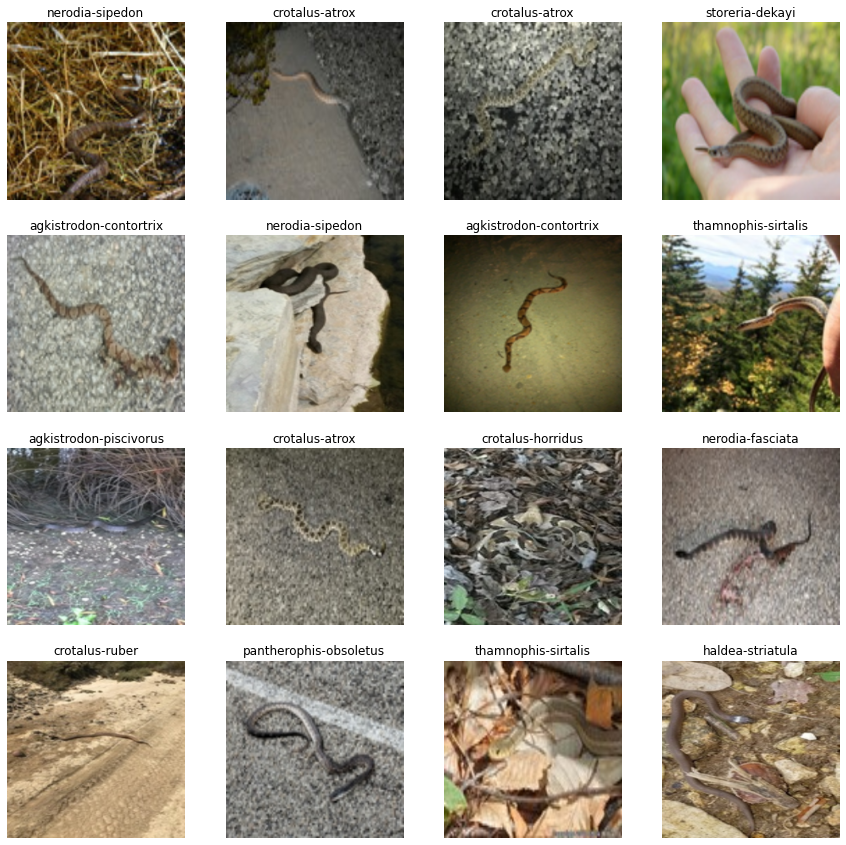

In [146]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):  
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Data Augmentation 

In [149]:
# Setting The AUTOTUNE
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Augmentation PipeLine
data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal",
                                                                                      input_shape=(img_height, img_width,3)),
                                         layers.experimental.preprocessing.RandomContrast(0.2), 
                                         layers.experimental.preprocessing.RandomRotation(0.2),
                                         layers.experimental.preprocessing.RandomZoom(0.2)])

# Model Creation

In [211]:
# model = tf.keras.Sequential([data_augmentation, 
#                              layers.experimental.preprocessing.Rescaling(1./255),  
#                              layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
#                              layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
#                              layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),  
#                              layers.Dropout(0.2),
#                              layers.Flatten(),  
#                              layers.Dense(128, activation='relu'),  
#                              layers.Dense(num_classes)])


model = Sequential([data_augmentation,
                    layers.experimental.preprocessing.Rescaling(1./255),
                    layers.Conv2D(16, 3, padding='same', activation='relu'), layers.MaxPooling2D(),
                    layers.Conv2D(32, 3, padding='same', activation='relu'), layers.MaxPooling2D(),
                    layers.Conv2D(64, 3, padding='same', activation='relu'), layers.MaxPooling2D(),
                    layers.Dropout(0.2),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(num_classes)])


checkpoint = ModelCheckpoint(filepath='best_weights.hdf5',
                             save_weights_only=True,
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True)

model.compile(optimizer='adam',    
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),    
              metrics=['accuracy'])

model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_23 (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_38 (Rescaling)     (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 56, 56, 64)      

# Training 

In [212]:
hist = model.fit(train_ds,
                 validation_data=val_ds, 
                 epochs=30, 
                 callbacks = [checkpoint])

Epoch 1/30
138/138 [==============================] - 12s 86ms/step - loss: 3.4522 - accuracy: 0.0876 - val_loss: 3.3850 - val_accuracy: 0.1026
Epoch 2/30
138/138 [==============================] - 12s 84ms/step - loss: 3.3791 - accuracy: 0.0921 - val_loss: 3.3651 - val_accuracy: 0.0963
Epoch 3/30
138/138 [==============================] - 11s 83ms/step - loss: 3.3649 - accuracy: 0.0905 - val_loss: 3.3489 - val_accuracy: 0.0972
Epoch 4/30
138/138 [==============================] - 11s 83ms/step - loss: 3.3532 - accuracy: 0.0935 - val_loss: 3.3397 - val_accuracy: 0.1008
Epoch 5/30
138/138 [==============================] - 11s 83ms/step - loss: 3.3392 - accuracy: 0.1057 - val_loss: 3.3308 - val_accuracy: 0.1063
Epoch 6/30
138/138 [==============================] - 11s 83ms/step - loss: 3.3134 - accuracy: 0.1137 - val_loss: 3.2960 - val_accuracy: 0.1135
Epoch 7/30
138/138 [==============================] - 12s 84ms/step - loss: 3.3008 - accuracy: 0.1166 - val_loss: 3.2853 - val_accuracy:

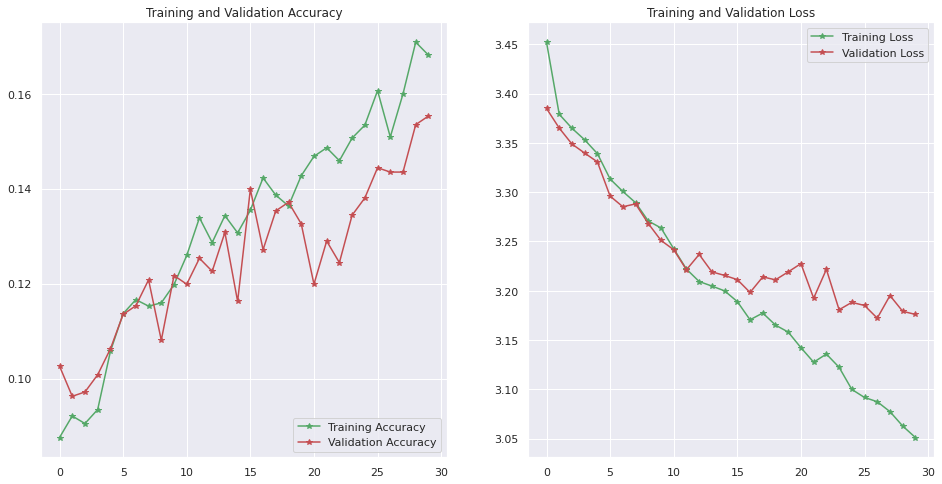

In [213]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy', marker = '*', color = 'g')
plt.plot(val_acc, label='Validation Accuracy', marker = '*', color = 'r')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss', marker = '*', color = 'g')
plt.plot(val_loss, label='Validation Loss', marker = '*', color = 'r')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Generating Prediciton on Unknown Imageset


In [214]:
from tensorflow import keras

def get_prediction(model, path): 
    img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    return class_names[np.argmax(score)], 100 * np.max(score)


test_paths = [test_dir + '/' + path for path in  test_df['image_id']]
predictions = []
from tqdm import tqdm
for path in tqdm(test_paths):
    predictions.append(get_prediction(model, path)[0])

100%|██████████| 2361/2361 [01:16<00:00, 30.83it/s]


In [215]:
# Removing the previously added .jpg from the image_id
sub = test_df.copy()
sub['image_id'] = [a[:-4 ] for a in test_df['image_id']]
sub['breed'] = predictions
sub.to_csv('submission_run_train.csv', index = False)

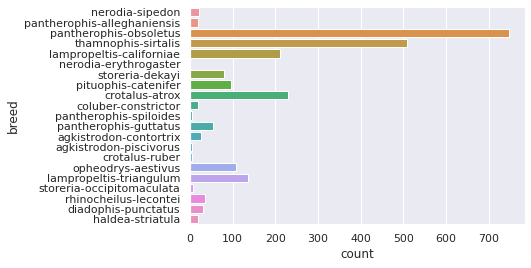

In [216]:
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot(y="breed", data=sub)

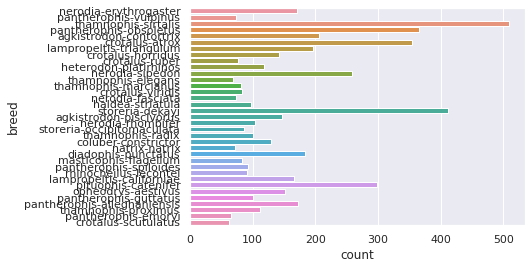

In [217]:
ax = sns.countplot(y="breed", data=train_df)